# Statistiek evaluatie - Deel 1 - Modeling production process

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import skew
from scipy.special import erf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# Setting plot configurations
plt.rc('figure', figsize=(10, 6))
plt.rc('font', size=16)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## 1. Loading data

In [2]:
# Defining function that loads JSON files in daily_prod dataframe
def load_daily_site_prod(production_site, daily_prod):
    """ Function takes the following parameters:
        * site : factory location where the production is taking place
        * daily_prd : Pandas dataframe where production is being stored for analysis"""
    # declare list variable to temporarily store production data 
    daily_site_prod = []
    input_folder = '../data/input/daily_production/'
    file_path = os.path.join(input_folder, production_site)
    
    # Iterate through each file in the directory
    for filename in os.listdir(file_path):
        if filename.endswith('.json'):
            full_path = os.path.join(file_path, filename)
            # Read JSON file into a dictionary
            with open(full_path, 'r') as file:
                json_data = json.load(file)
            # Append dictionary to the list
            daily_site_prod.append(json_data)

    # convert list (of dictionaries) to dataframe
    site_data = pd.DataFrame(daily_site_prod)
    # Add site info to records
    site_data['site'] = production_site

    daily_prod = pd.concat([daily_prod, site_data])
    return daily_prod

# Load master_data.json
master_data = '../data/input/master_data.json'
with open(master_data, 'r') as file:
    master_data_file = json.load(file)

# Loading site data
sites = ['BRU', 'STO']
daily_prod = pd.DataFrame()
for site in sites:
    daily_prod = load_daily_site_prod(site, daily_prod)

# Printing to check if data was loaded correctly
print(master_data_file)
print()
print(daily_prod.info())
print()
daily_prod.head()

{'BRU msr': 1244, 'STO msr': 274}

<class 'pandas.core.frame.DataFrame'>
Index: 3660 entries, 0 to 1829
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DoW             3660 non-null   object
 1   hour            3660 non-null   int64 
 2   minute          3660 non-null   int64 
 3   date            3660 non-null   object
 4   maintenance     3660 non-null   object
 5   prod_loss       3660 non-null   object
 6   prod_loss_perc  3660 non-null   object
 7   production      3660 non-null   object
 8   site            3660 non-null   object
dtypes: int64(2), object(7)
memory usage: 285.9+ KB
None



,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,site
0,Tuesday,1,0,09-22-2020 00:00:00.0000,No,225,18,1019,BRU
1,Monday,1,0,01-22-2018 00:00:00.0000,No,255,20,989,BRU
2,Wednesday,1,0,08-21-2019 00:00:00.0000,No,138,11,1106,BRU
3,Tuesday,1,0,08-21-2018 00:00:00.0000,No,302,24,942,BRU
4,Wednesday,1,0,09-22-2021 00:00:00.0000,No,211,17,1033,BRU


## 2. Preprocessing data

In [3]:
def preprocess(df):
    """ Function takes dataframe with all production for all sites as input parameter and 
    returns a dataframe excluding maintenance days and with converted field datatypes."""
    
    # Exclude maintenance days
    df = df[df['maintenance'] == 'No']
    
    # Convert field datatypes
    df = df.copy()
    df.date = pd.to_datetime(df.date)
    df.prod_loss_perc = df.prod_loss_perc.astype(int)
    df.prod_loss = df.prod_loss.astype(int)
    df.production = df.production.astype(int)
    return df

# Filtering out maintenance days and converting datatypes
daily_prod_excl_maint = preprocess(daily_prod)

# Visual inspection of dataframe
daily_prod_excl_maint.info()
daily_prod_excl_maint.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3452 entries, 0 to 1828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DoW             3452 non-null   object        
 1   hour            3452 non-null   int64         
 2   minute          3452 non-null   int64         
 3   date            3452 non-null   datetime64[ns]
 4   maintenance     3452 non-null   object        
 5   prod_loss       3452 non-null   int64         
 6   prod_loss_perc  3452 non-null   int64         
 7   production      3452 non-null   int64         
 8   site            3452 non-null   object        
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 269.7+ KB


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,site
0,Tuesday,1,0,2020-09-22,No,225,18,1019,BRU
1,Monday,1,0,2018-01-22,No,255,20,989,BRU
2,Wednesday,1,0,2019-08-21,No,138,11,1106,BRU
3,Tuesday,1,0,2018-08-21,No,302,24,942,BRU
4,Wednesday,1,0,2021-09-22,No,211,17,1033,BRU


## 3. Exploratory Data Analysis

### 3.0 Explore maintenance and calculate percentage rates

#### Note: This is for information purpose only, as the assignment was to exclude maintenance days. The calculations from section 3.1 onwards are all done with the data excluding maintenance days

In [4]:
# Count maintenance and no-maintenance days for each site
maintenance_counts = daily_prod.groupby(['site', 'maintenance']).size().unstack(fill_value=0)

# Calculate total days per site
total_days_per_site = maintenance_counts.sum(axis=1)

# Extract counts for maintenance and no-maintenance days
maintenance_days_per_site = maintenance_counts.get('Yes', 0)
no_maintenance_days_per_site = maintenance_counts.get('No', 0)

# Calculate percentage of maintenance days per site
maintenance_perc_per_site = (maintenance_days_per_site / total_days_per_site) * 100

# Print results for each site
for site in ['BRU', 'STO']:
    total_days = total_days_per_site.get(site, 0)
    maintenance_days = maintenance_days_per_site.get(site, 0)
    no_maintenance_days = no_maintenance_days_per_site.get(site, 0)
    maintenance_perc = maintenance_perc_per_site.get(site, 0)

    print(f"Total days in {site}: {total_days}")
    print(f"Maintenance days in {site}: {maintenance_days}")
    print(f"No maintenance days in {site}: {no_maintenance_days}")
    print(f"Percentage of maintenance days in {site}: {maintenance_perc:.2f}%")
    print()


Total days in BRU: 1830
Maintenance days in BRU: 94
No maintenance days in BRU: 1736
Percentage of maintenance days in BRU: 5.14%

Total days in STO: 1830
Maintenance days in STO: 114
No maintenance days in STO: 1716
Percentage of maintenance days in STO: 6.23%



### 3.2 Calculate 0 production probability per site

In [5]:
# Group data by site and calculate zero and non-zero production counts
prod_counts = daily_prod_excl_maint.groupby(['site', 'production']).size().unstack(fill_value=0)

# Get zero production counts and total counts for each site
zero_prod_counts_per_site = prod_counts.get(0, 0)
total_counts_per_site = prod_counts.sum(axis=1)

# Calculate the probability of zero production for each site
prob_zero_prod_per_site = zero_prod_counts_per_site / total_counts_per_site * 100

# Extract and print results for each site
for site in ['BRU', 'STO']:
    total_days = total_counts_per_site.get(site, 0)
    zero_days = zero_prod_counts_per_site.get(site, 0)
    prob_zero_prod = prob_zero_prod_per_site.get(site, 0)

    print(f"Total no maintenance days in {site}: {total_days}")
    print(f"Zero production days in {site}: {zero_days}")
    print(f"Percentage of zero production day for {site}: {prob_zero_prod:.2f}%")
    print()


Total no maintenance days in BRU: 1736
Zero production days in BRU: 308
Percentage of zero production day for BRU: 17.74%

Total no maintenance days in STO: 1716
Zero production days in STO: 126
Percentage of zero production day for STO: 7.34%



### 3.3 Visualize production distribution

<Axes: >

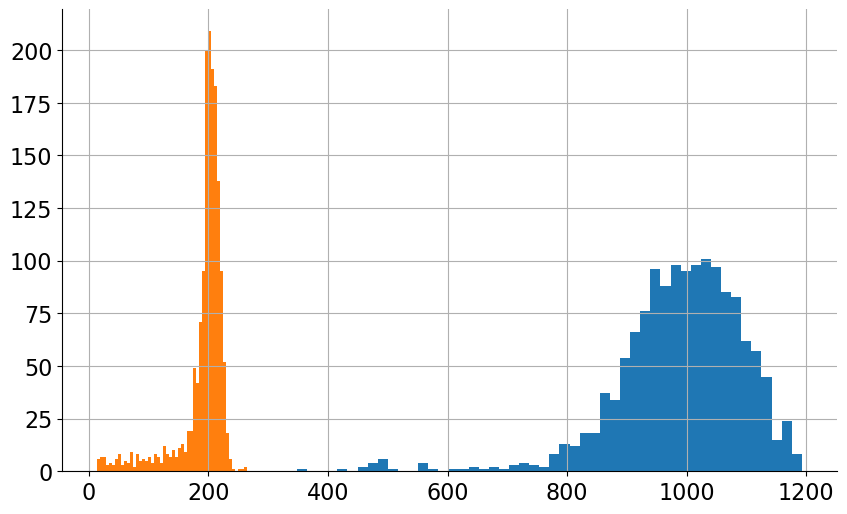

In [6]:
# Visualize distribution of production on sites
daily_prod_bru = daily_prod_excl_maint[(daily_prod_excl_maint['site'] == 'BRU') & (daily_prod_excl_maint.production != 0)]
daily_prod_bru['production'].hist(bins=50)

daily_prod_sto = daily_prod_excl_maint[(daily_prod_excl_maint['site'] == 'STO') & (daily_prod_excl_maint.production != 0)]
daily_prod_sto['production'].hist(bins=50)

In [7]:
stats.norm.fit(daily_prod_bru['production'])

(989.218487394958, 108.90790262811456)

Mean BRU production: 989.22
Std BRU production: 108.91


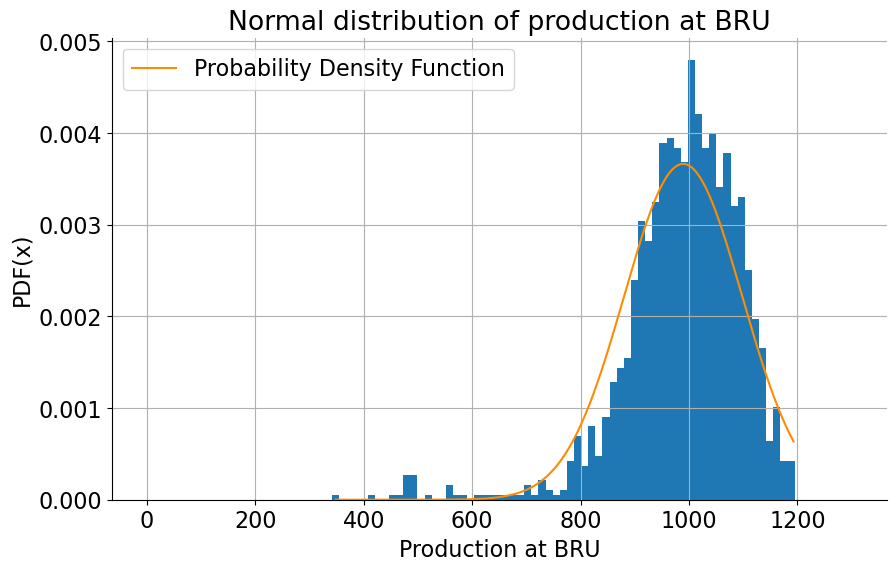

In [8]:
# Define BRU production distribution and calculate PDF

# Plot BRU production values in histogram
daily_prod_bru['production'].hist(bins=np.linspace(0, 1300, 100), density = True)

# Define PDF parameters
mean, std_dev = stats.norm.fit(daily_prod_bru['production'])

print('Mean BRU production:', round(mean, 2))
print('Std BRU production:', round(std_dev, 2))

# Generate values that fit my data
x_values = np.linspace(np.min(daily_prod_bru['production']), np.max(daily_prod_bru['production']), 1000)

# Calculate PDF
pdf_values = stats.norm.pdf(x_values, loc=mean, scale=std_dev)

# Plot the PDF
plt.plot(x_values, pdf_values, color='darkorange', label='Probability Density Function')
plt.title('Normal distribution of production at BRU')
plt.xlabel('Production at BRU')
plt.ylabel('PDF(x)')
plt.grid(True)
plt.legend()
plt.show()

Mean STO production: 190.97
Std STO production: 40.18

Adjusted the mean (205 instead of 190) & std (15 instead of 40) of the PDF to better fit the actual distribution (visually)


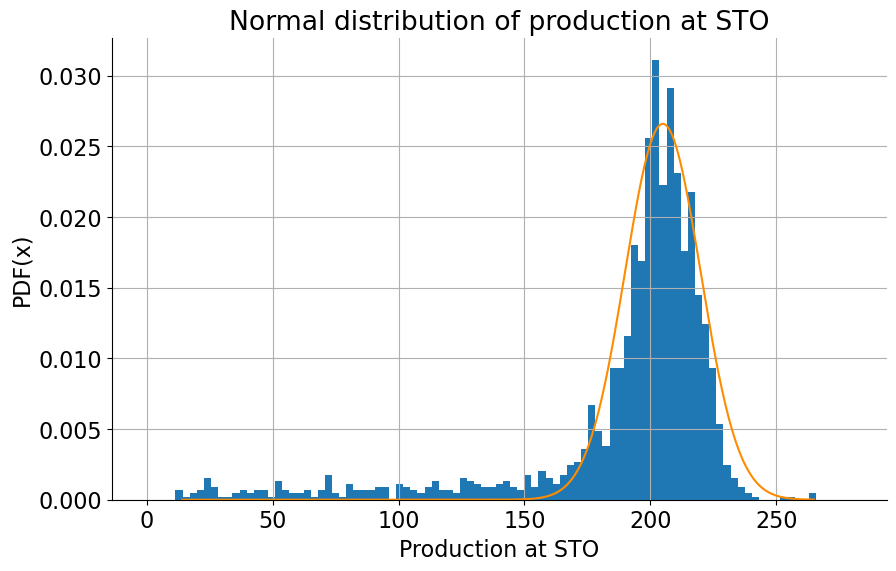

In [9]:
# Calculate PDF of distribution at STO

# Plot STO production values in histogram
daily_prod_sto['production'].hist(bins=np.linspace(0, 280, 100), density = True)

# Calculate PDF parameters
mean, std_dev = stats.norm.fit(daily_prod_sto['production'])
print('Mean STO production:', round(mean, 2))
print('Std STO production:', round(std_dev, 2))

# Generate values that fit my data
x_values = np.linspace(np.min(daily_prod_sto['production']), np.max(daily_prod_sto['production']), 1000)

# Calculate PDF => adjusted the loc and scale parameters to better fit the actual distribution
pdf_values = stats.norm.pdf(x_values, loc=205, scale=15)

print()
print('Adjusted the mean (205 instead of 190) & std (15 instead of 40) of the PDF to better fit the actual distribution')

# Plot the PDF
plt.plot(x_values, pdf_values, color='darkorange', label='Probability Density Function')
plt.title('Normal distribution of production at STO')
plt.xlabel('Production at STO')
plt.ylabel('PDF(x)')
plt.grid(True)
plt.show()

In [10]:
# Calculate percentage of production in STO that falls outside of the normal distribution with mean 205 and std_dev of 15

round((daily_prod_sto[daily_prod_sto['production'] < 150].shape[0] / daily_prod_sto[daily_prod_sto['production'] >= 150].shape[0]) * 100, 2)

# This is currently not taken into account in the simulation, but could be considered statistically significant enough when modelling the in a real life scenario.

11.58

### Conclusion: BRU and STO both have a left skewed normal distribution if 0 production days are not taken into account.
### For 

## 4.1. Modeling production capability BRU

### 4.1.1 Calculate probability of productive days taking into account maintenance and 0 production days

In [11]:
# Define parameters
num_days = 100  # Number of days to simulate

# calculate the probability of a non-maintenance day by substracting the prob of maintenance from 1
prob_no_maint_bru = 1 - (prob_maint_bru / 100)
# calculate the probability of a +0 production day by substracting the prob of a 0-production day from 1
prob_no_zero_prod_bru = 1 - (prob_zero_prod_bru / 100)

# Calculate the overal probability a - higher-than-zero - production day (no maintenance with non-zero production day)
prob_no_maint_no_zero_prod_bru = prob_no_maint_bru * prob_no_zero_prod_bru

# Simulate production scenario for num_days taking into account the overal probability of a - higher-than-zero - production day
no_maint_no_zero_prod_days = stats.binom.rvs(1, prob_no_maint_no_zero_prod_bru, size=num_days)

# Print out the probability and the result of the simulation
print(f'The probability of days with  more than 0 production is: {prob_no_maint_no_zero_prod_bru:.2f}%')
print()
print(f'A potential distribution of {num_days} production days taking into account zero production-days and maintenance on site BRU: ')
print()
print(no_maint_no_zero_prod_days)

NameError: name 'prob_maint_bru' is not defined

### 4.1.2 Simulate production for x days

In [ ]:
def production_simulation(num_days, num_simulations):
    """Simulate production on a number of days (num_days) and repeats simulation (num_simulations)"""
    
    # declare list to store production values for all simulations
    simulated_data = []
    for sim in range(num_simulations):
        production_data = []
        
        # simulate distribution of days, taking into account the probability for maintenance and days with 0 production
        no_maint_no_zero_prod_days = stats.binom.rvs(1, prob_no_maint_no_zero_prod_bru, size=num_days)
        
        for day in no_maint_no_zero_prod_days:
            if day == 0: 
                # this is either a maintenance day, or a day with 0 production
                production_data.append(0)
            else: 
                # this is a day with a production > 0 
                daily_production = np.random.normal(daily_prod_bru['production'].mean(), daily_prod_bru['production'].std())
                production_data.append(int(daily_production))
        
        # append simulation to list
        simulated_data.append(production_data)
    return simulated_data

my_simulation_bru = production_simulation(30, 10**3)

# Calculate total production for each simulation
simulations_total_prod_bru = []
for row in my_simulation_bru:
    prod_per_numdays = np.sum(row)
    simulations_total_prod_bru.append(prod_per_numdays)

plt.hist(simulations_total_prod_bru, bins=70)
plt.xlabel('Total production')
plt.ylabel('Frequency')
plt.title(f'Total production in BRU on {num_days} days')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
# Sorting the data
sorted_data = np.sort(simulations_total_prod_bru)

# Calculate the cumulative probabilities
cumulative_prob = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the empirical CDF
plt.plot(sorted_data, cumulative_prob, marker='.', linestyle='none', color="seagreen")
plt.xlabel('Production')
plt.ylabel('Cumulative Probability')
plt.title(f'Empirical Cumulative Distribution Function (CDF) for BRU  {num_days} days')
plt.grid(True)
plt.show()

## 4.2 Modeling production capability STO

### 4.2.1 Calculate probability of productive days taking into account maintenance and 0 production days

In [ ]:
# Define parameters
num_days = 100  # Number of days to simulate

# calculate the probability of a non-maintenance day by substracting the prob of maintenance from 1
prob_no_maint_sto = 1 - (prob_maint_sto / 100)
# calculate the probability of a +0 production day by substracting the prob of a 0-production day from 1
prob_no_zero_prod_sto = 1 - (prob_zero_prod_sto / 100)

# Calculate the overal probability a - higher-than-zero - production day (no maintenance with non-zero production day)
prob_no_maint_no_zero_prod_sto = prob_no_maint_sto * prob_no_zero_prod_sto

# Simulate production scenario for num_days taking into account the overal probability of a - higher-than-zero - production day
no_maint_no_zero_prod_days = stats.binom.rvs(1, prob_no_maint_no_zero_prod_sto, size=num_days)

# Print out the probability and the result of the simulation
print(f'The probability of days with  more than 0 production is: {prob_no_maint_no_zero_prod_sto:.2f}%')
print()
print(f'A potential distribution of {num_days} production days taking into account zero production-days and maintenance on site STO: ')
print()
print(no_maint_no_zero_prod_days)

### 4.1.2 Simulate production for x days

In [ ]:
def production_simulation(num_days, num_simulations):
    """Simulate production on a number of days (num_days) and repeats simulation (num_simulations)"""
    
    # declare list to store production values for all simulations
    simulated_data = []
    for sim in range(num_simulations):
        production_data = []
        
        # simulate distribution of days, taking into account the probability for maintenance and days with 0 production
        no_maint_no_zero_prod_days = stats.binom.rvs(1, prob_no_maint_no_zero_prod_sto, size=num_days)
        
        for day in no_maint_no_zero_prod_days:
            if day == 0: 
                # this is either a maintenance day, or a day with 0 production
                production_data.append(0)
            else: 
                # this is a day with a production > 0
                daily_production = np.random.normal(205, 15)
                # daily_production = np.random.normal(daily_prod_sto['production'].mean(), daily_prod_sto['production'].std())
                production_data.append(int(daily_production))
        
        # append simulation to list
        simulated_data.append(production_data)
    return simulated_data

my_simulation_sto = production_simulation(30, 10**3)

# Calculate total production for each simulation
simulations_total_prod_sto = []
for row in my_simulation_sto:
    prod_per_numdays = np.sum(row)
    simulations_total_prod_sto.append(prod_per_numdays)

plt.hist(simulations_total_prod_sto, bins=70)
plt.xlabel('Total production')
plt.ylabel('Frequency')
plt.title(f'Total production in STO on {num_days} days')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
def production_simulation(num_days, num_simulations):
    """Simulate production on a number of days (num_days) and repeats simulation (num_simulations)"""
    
    # declare list to store production values for all simulations
    simulated_data = []
    for sim in range(num_simulations):
        production_data = []
        
        # simulate distribution of days, taking into account the probability for maintenance and days with 0 production
        no_maint_no_zero_prod_days = stats.binom.rvs(1, prob_no_maint_no_zero_prod_sto, size=num_days)
        
        for day in no_maint_no_zero_prod_days:
            if day == 0: 
                # this is either a maintenance day, or a day with 0 production
                production_data.append(0)
            else: 
                # this is a day with a production > 0
                # daily_production = np.random.normal(205, 15)
                daily_production = np.random.normal(daily_prod_sto['production'].mean(), daily_prod_sto['production'].std())
                production_data.append(int(daily_production))
        
        # append simulation to list
        simulated_data.append(production_data)
    return simulated_data

my_simulation_sto = production_simulation(30, 10**3)

# Calculate total production for each simulation
simulations_total_prod_sto = []
for row in my_simulation_sto:
    prod_per_numdays = np.sum(row)
    simulations_total_prod_sto.append(prod_per_numdays)

plt.hist(simulations_total_prod_sto, bins=70)
plt.xlabel('Total production')
plt.ylabel('Frequency')
plt.title(f'Total production in STO on {num_days} days')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
# Sorting the data
sorted_data = np.sort(simulations_total_prod_sto)

# Calculate the cumulative probabilities
cumulative_prob_sto = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the empirical CDF
plt.plot(sorted_data, cumulative_prob_sto, marker='.', linestyle='none', color="seagreen")
plt.xlabel('Production')
plt.ylabel('Cumulative Probability')
plt.title(f'Empirical Cumulative Distribution Function (CDF) for BRU  {num_days} days')
plt.grid(True)
plt.show()